In [ ]:
##WEEK 02 ASSIGNMENT : TITANIC DATA

###Step 1: Business Goal
###Step 2: Load and inspect Data
###Step 3: Train-Test Split (df_train and df_test)
###Step 4: Exploratory Data Analysis on df_train 
## Step 5: Baseline model + Evaluation metrics - DecisionTree Classifier, Logistic Regression, Random Forest
###Step 6: Feature Engineering on df_train and df_test (Pipeline + Feature expansion + feature selection)
###Step 7: Iterate the transformed models. Optimize hyperparameters 
###Step 8: Make predictions for Titanic Kaggle challenge and submit results 


In [26]:
#Packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant 
from statsmodels.api import OLS, add_constant
from sklearn.feature_selection import RFE
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve, auc, roc_curve
from sklearn.model_selection import cross_val_score

pd.options.mode.chained_assignment = None 


In [ ]:
#Step 1: Business Goal: Predict correctly the survivors of titanic using train.csv data set 

In [50]:
#Step 2: Load and Inspect Data

df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Missing values and data formating 

#PassengerId, Name, Sex, Ticket, Survived
df['PassengerId'] = df['PassengerId'].astype('category')

#Age
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Age'] = pd.to_numeric(df['Age'])
df['Age'].fillna(df['Age'].mean(), inplace=True)

#Cabin
df['Cabin'].fillna('not identified', inplace=True)

#Embarked 
df['Embarked'].dropna(inplace=True)




In [741]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [742]:
# Variance Inflation Factor (VIF between 5-10 means there is multicolinearity)
X = df[['Pclass', 'Age', 'SibSp','Parch','Fare']]
X_vif = add_constant(X) 
pd.Series([variance_inflation_factor(X_vif.values, i) 
           for i in range(X_vif.shape[1])], 
            index=X_vif.columns)

const     29.309092
Pclass     1.653412
Age        1.195003
SibSp      1.274264
Parch      1.265390
Fare       1.586539
dtype: float64

<AxesSubplot:>

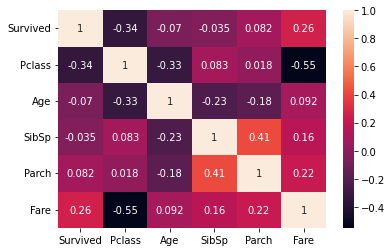

In [743]:
sns.heatmap(df.corr(), annot= True)
# Potential good predictors of survival status: Pclass, Age, Fare
# Potential multicolinearity between pclass and fare 

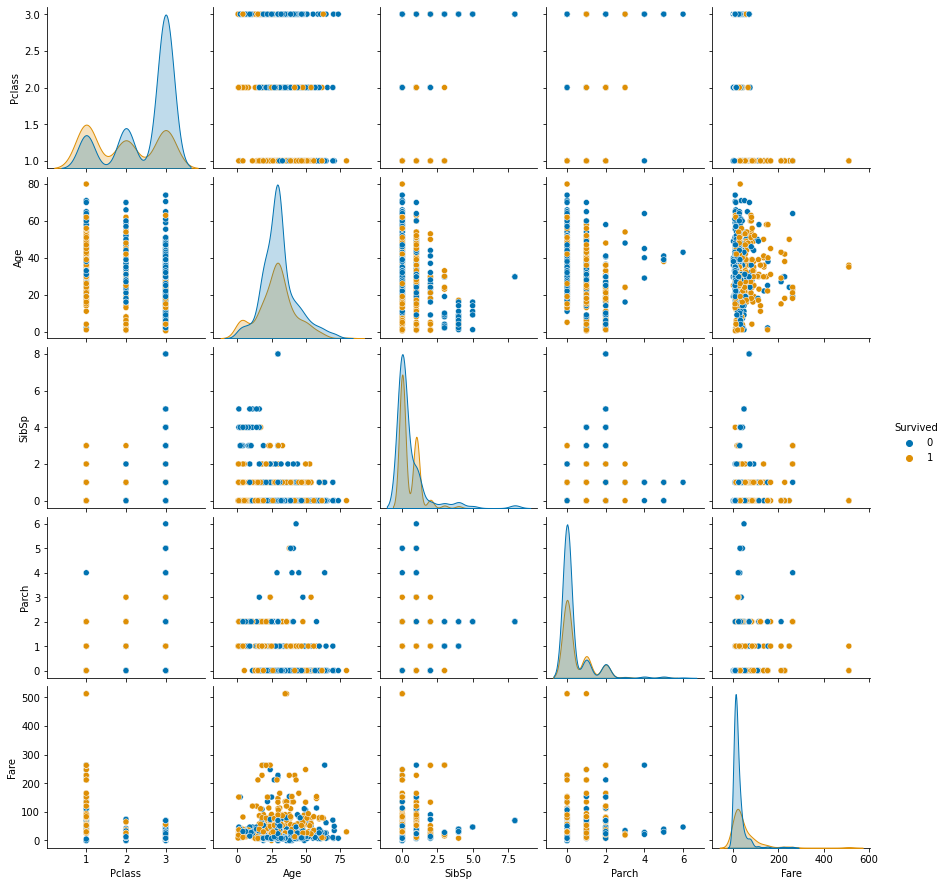

In [744]:
sns.pairplot(df, hue ='Survived')

In [ ]:
#Step 3: Train-Test Split (df_train and df_test)

In [5]:
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train.shape, df_test.shape

((712, 12), (179, 12))

In [150]:
#Step 4: Exploratory Data Analysis on df_train

In [746]:
# Survival Rate 

surv = df_train[['Survived','PassengerId']].groupby('Survived').count()
surv.reset_index(inplace=True)
surv

,Survived,PassengerId
0,0,434
1,1,278


In [749]:
round(surv['PassengerId']/surv['PassengerId'].sum(),3) #survival rate of 39%, we have imbalanced data , more people died than survived 

0    0.61
1    0.39
Name: PassengerId, dtype: float64

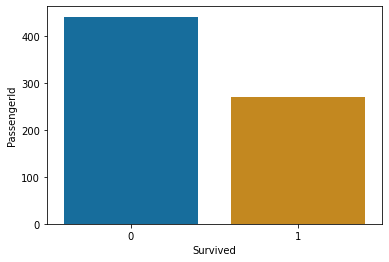

In [647]:
ax = sns.barplot(data=surv, x='Survived', y='PassengerId')

In [750]:
# Gender and Age 
df_train[['Survived','Sex','PassengerId']].groupby(['Sex', 'Survived']).count()


PassengerId
Sex    Survived             
female 0                  69
       1                 188
male   0                 365
       1                  90

<AxesSubplot:xlabel='Sex', ylabel='Count'>

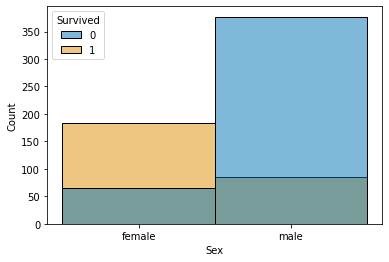

In [649]:
sns.histplot(data=df_train, x='Sex', hue='Survived') #The survival rate looks better for women 

<AxesSubplot:xlabel='Age', ylabel='Count'>

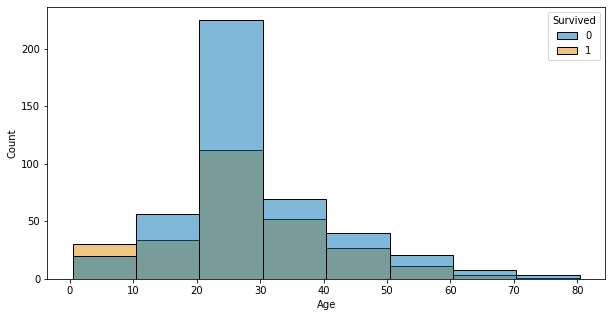

In [908]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_train, x='Age', hue='Survived', binwidth=10) 
#there are a lot of babies surviving, and the surviving rate looks worse for people aged 20-30, where also most of the population lies 

In [752]:
df_train[['Survived','Age','Sex']].groupby(['Survived','Sex']).describe() # the survived group has more people on age extremes, while the non survived group concentrates a lot on group 20-30 years old

Age                                                      \
                 count       mean        std   min    25%        50%   75%   
Survived Sex                                                                 
0        female   69.0  26.011415  11.675804  2.00  18.00  28.000000  30.0   
         male    365.0  31.355959  12.361079  2.00  24.00  29.699118  36.0   
1        female  188.0  28.787093  13.049170  0.75  21.75  29.699118  35.0   
         male     90.0  26.046186  15.072883  0.42  19.00  29.000000  32.0   

                       
                  max  
Survived Sex           
0        female  57.0  
         male    74.0  
1        female  63.0  
         male    80.0

In [754]:
# Embarkation Characteristics (Port, Cabin, Fare, Class) 
# strong correlation between Fare and Class indicates redundant information

first_class = df_train[(df_train['Pclass'] == 1)]
first_survived = first_class[first_class['Survived']== 1].count()
first_total = first_class['Survived'].count()
first_proportion = first_survived/first_total 
round(first_proportion['PassengerId'],3) 
# survival rate on 1st class is of 62.1% while in the overall training set is of 38%


0.621

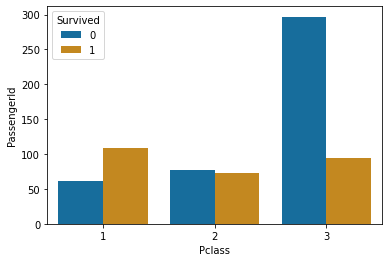

In [675]:
gb = df_train[['PassengerId','Pclass','Survived']].groupby(['Pclass','Survived']).count()
gb.reset_index(inplace=True)
ax = sns.barplot(x="Pclass", y="PassengerId" , hue='Survived', data=gb)
# Lower survival on 3rd class

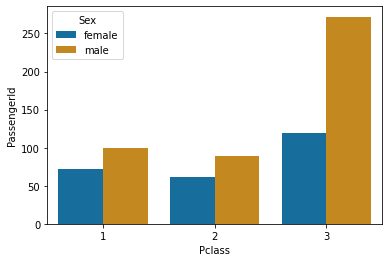

In [676]:
gb = df_train[['PassengerId','Pclass','Sex']].groupby(['Pclass','Sex']).count()
gb.reset_index(inplace=True)
ax = sns.barplot(x="Pclass", y="PassengerId", hue="Sex", data=gb)
# 3rd class has more males
# Lower survival rate on men could be also related with the fact that they are concentrated on 3rd class

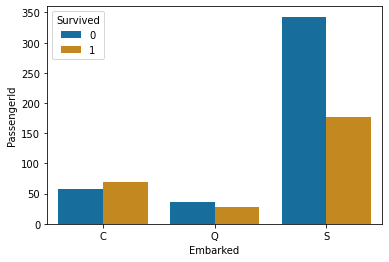

In [685]:
gb = df_train[['PassengerId','Survived','Embarked']].groupby(['Embarked','Survived']).count()
gb.reset_index(inplace=True)
ax = sns.barplot(x='Embarked', y= "PassengerId", hue="Survived", data=gb)
# The survival rate looks bad for passengers who embarqued in ports Q and S

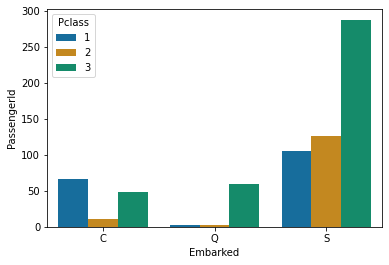

In [686]:
gb = df_train[['PassengerId','Pclass','Embarked']].groupby(['Embarked','Pclass']).count()
gb.reset_index(inplace=True)
ax = sns.barplot(x='Embarked', y= "PassengerId", hue="Pclass", data=gb)
# Port Q seems to have only 3rd class passengers and port S contains more than half of 3rd class passengers

<AxesSubplot:xlabel='Fare', ylabel='Count'>

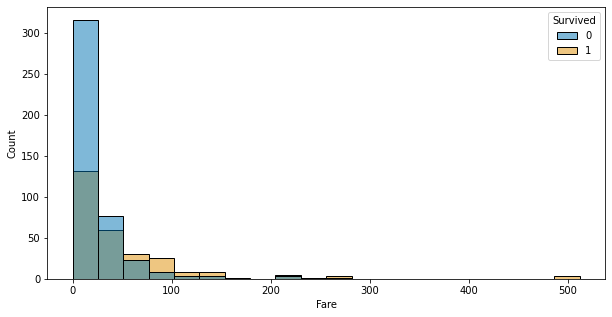

In [722]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_train, x='Fare', hue='Survived', bins=20)
# It seems survival rate is positively correlated with ticket fare, which is also related with passenger classes


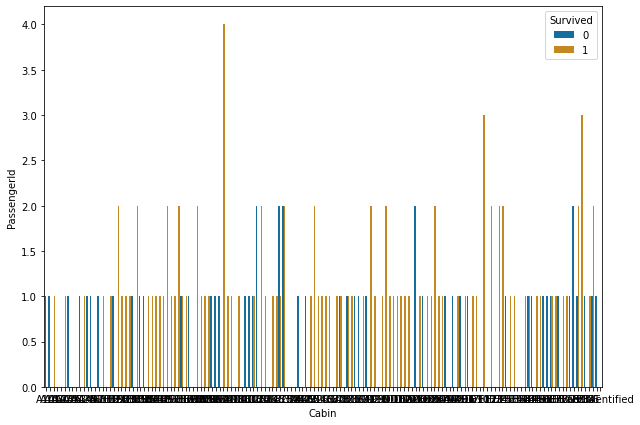

In [806]:
gb = df_train[['Cabin','PassengerId', 'Survived']].groupby(['Cabin', 'Survived']).count()
gb.reset_index(inplace=True)
gb.sort_values(by='PassengerId', ascending=False)
plt.figure(figsize=(10,7))
sns.set_palette('colorblind')
ax = sns.barplot(x='Cabin',  y='PassengerId', 
                 hue='Survived', data=gb[gb['Cabin'] != 'not identified'])

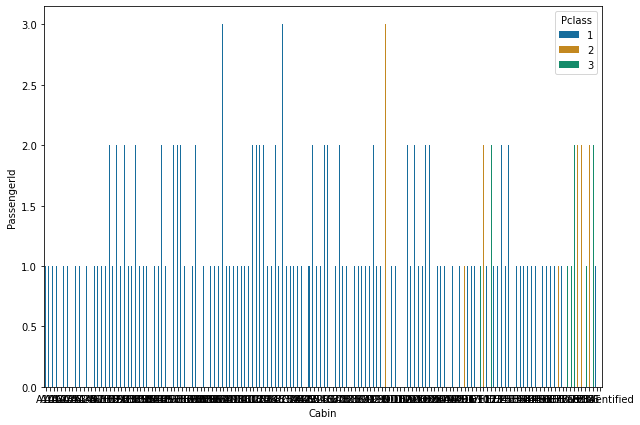

In [735]:
# Most of the identified cabin passengers had survived. They also belonged mostly to 1st class.

gb = df_train[['Cabin','PassengerId', 'Pclass']].groupby(['Cabin', 'Pclass']).count()
gb.reset_index(inplace=True)
gb.sort_values(by='PassengerId', ascending=False)
plt.figure(figsize=(10,7))
sns.set_palette('colorblind')
ax = sns.barplot(x='Cabin',  y='PassengerId', 
                 hue='Pclass', data=gb[gb['Cabin'] != 'not identified'])



In [736]:
gb.describe()
# At least 50% of the passengers in cabines belonged to 1st class. 
#Only 25% of the cabines had more than one passenger

,Pclass,PassengerId
count,444.000000,444.000000
mean,2.000000,1.603604
std,0.817418,19.280760
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,3.000000,385.000000


In [6]:
# Family Characteristics(Sibsp,Parch)


# Test data 
family = df_test[['PassengerId','Name', 'SibSp','Parch','Survived', 'Cabin','Pclass']]
family.set_index('PassengerId',inplace=True)
family['Surname'] = family['Name'].str.split(expand=True, n=2, pat=',')[0]
family['FirstName'] = family['Name'].str.split(expand=True, n=2, pat=',')[1]
family['PrefixName'] = family['FirstName'].str.split(expand=True, n=2, pat='.')[0]
family['FirstName'] = family['FirstName'].str.split(expand=True, n=2, pat='.')[1]
family.sort_values(by='Surname', inplace=True)
df_test = df_test.merge(family)

# Train data 

family = df_train[['PassengerId','Name', 'SibSp','Parch','Survived', 'Cabin','Pclass']]
family.set_index('PassengerId',inplace=True)
family['Surname'] = family['Name'].str.split(expand=True, n=2, pat=',')[0]
family['FirstName'] = family['Name'].str.split(expand=True, n=2, pat=',')[1]
family['PrefixName'] = family['FirstName'].str.split(expand=True, n=2, pat='.')[0]
family['FirstName'] = family['FirstName'].str.split(expand=True, n=2, pat='.')[1]
family.sort_values(by='Surname', inplace=True)
df_train = df_train.merge(family)
family.tail(10)


,Name,SibSp,Parch,Survived,Cabin,Pclass,Surname,FirstName,PrefixName
PassengerId,,,,,,,,,
200,"Yrois, Miss. Henriette (""Mrs Harbeck"")",0,0,0,not identified,2,Yrois,"Henriette (""Mrs Harbeck"")",Miss
241,"Zabour, Miss. Thamine",1,0,0,not identified,3,Zabour,Thamine,Miss
112,"Zabour, Miss. Hileni",1,0,0,not identified,3,Zabour,Hileni,Miss
423,"Zimmerman, Mr. Leo",0,0,0,not identified,3,Zimmerman,Leo,Mr
560,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",1,0,1,not identified,3,de Messemaeker,Guillaume Joseph (Emma),Mrs
287,"de Mulder, Mr. Theodore",0,0,1,not identified,3,de Mulder,Theodore,Mr
283,"de Pelsmaeker, Mr. Alfons",0,0,0,not identified,3,de Pelsmaeker,Alfons,Mr
362,"del Carlo, Mr. Sebastiano",1,0,0,not identified,2,del Carlo,Sebastiano,Mr
154,"van Billiard, Mr. Austin Blyler",0,2,0,not identified,3,van Billiard,Austin Blyler,Mr


In [898]:
df_train['PrefixName'].unique()

array([' Mr', ' Mrs', ' Miss', ' Don', ' Master', ' Dr', ' Rev', ' Mlle',
       ' Ms', ' Capt', ' Lady', ' Sir', ' Mme', ' Jonkheer', ' Major'],
      dtype=object)

In [899]:
df_test['PrefixName'].unique()

array([' Mr', ' Mrs', ' Dr', ' Miss', ' the Countess', ' Master', ' Col'],
      dtype=object)

In [ ]:
special_prefix = ['Don', 'Master', 'Dr', 'Rev', 'Mlle', 'Mme', 'Jonkheer']


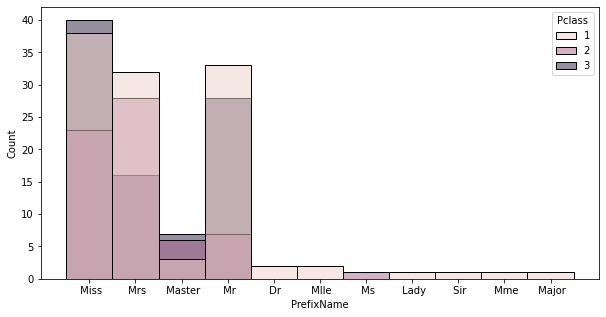

In [901]:
gb = family[['Name','PrefixName','Survived']].groupby(['Survived']).count()
gb.reset_index(inplace=True)
plt.figure(figsize=(10,5))
ax = sns.histplot(x='PrefixName', hue='Pclass'
                 , data=df_train[df_train['Survived'] == 1])

#Survival names: Major, Mme, Sir, Lady, Mlle, Dr, Countess

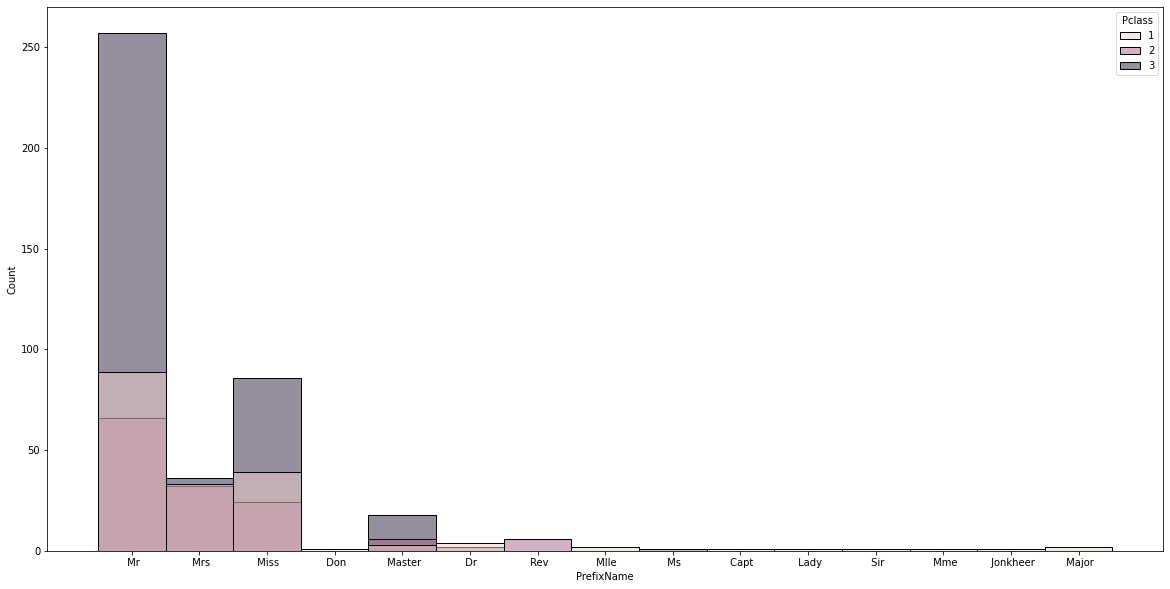

In [897]:
plt.figure(figsize=(20,10))
ax = sns.histplot(x='PrefixName', hue='Pclass'
                 , data=df_train)

In [876]:
gb.sort_values(by=['Survived', 'Name'], ascending=False).head(15)
df_train['family_size_cat'] = df_train['family_size'].map(family_size_map)
special_prefix 
# High probability of survival: Countess, Lady , Sir, Madame -- all prefixes connected to 1st class

,Pclass,PrefixName,Survived,Name
31,3,Miss,1,40
10,1,Miss,1,38
14,1,Mr,1,33
16,1,Mrs,1,32
25,2,Mrs,1,28
33,3,Mr,1,28
21,2,Miss,1,23
35,3,Mrs,1,16
23,2,Mr,1,7
29,3,Master,1,7


<AxesSubplot:xlabel='Surname', ylabel='Name'>

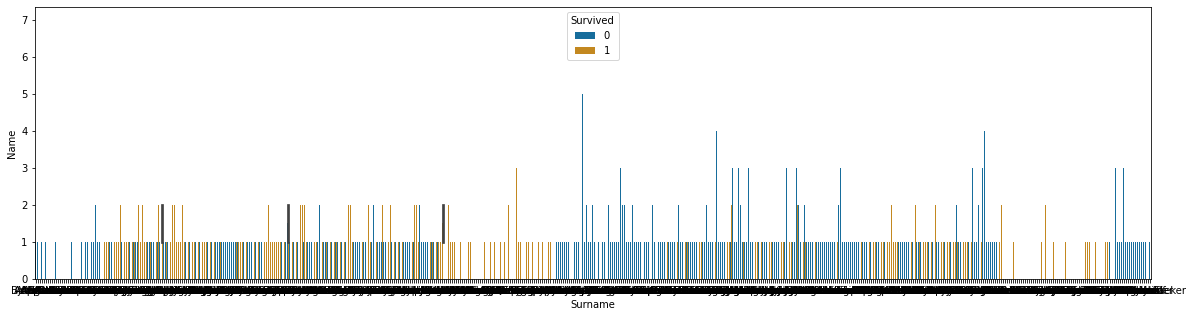

In [811]:
gb = family[['Surname','Name', 'Survived', 'Pclass']].groupby(['Pclass','Surname', 'Survived']).count()
gb.reset_index(inplace=True)
gb.sort_values(by='Surname', ascending=False)
plt.figure(figsize=(20,5))
sns.barplot(x='Surname',y ='Name', hue = 'Survived', data = gb)
# Families with more than 2 people on board tend to have higher mortality rate

In [812]:

gb[gb['Survived'] == 0].sort_values(by='Name', ascending=False).head(15)
# High mortality rate on families with many people on board and belonging to the 3rd Class

,Pclass,Surname,Survived,Name
544,3,Sage,0,7
297,3,Andersson,0,5
558,3,Skoog,0,5
372,3,Ford,0,4
517,3,Panula,0,4
537,3,Rice,0,4
390,3,Hansen,0,3
384,3,Gustafsson,0,3
381,3,Goodwin,0,3
442,3,Lefebre,0,3


In [813]:
gb[gb['Survived'] == 0].describe()
# 50% on non survivants were on 3rd class

,Pclass,Survived,Name
count,368.000000,368.0,368.000000
mean,2.442935,0.0,1.184783
std,0.786122,0.0,0.638106
min,1.000000,0.0,1.000000
25%,2.000000,0.0,1.000000
50%,3.000000,0.0,1.000000
75%,3.000000,0.0,1.000000
max,3.000000,0.0,7.000000


In [814]:
gb[gb['Survived'] == 1].sort_values(by='Name', ascending=False).head(10)

,Pclass,Surname,Survived,Name
309,3,Baclini,1,3
259,2,Richards,1,3
303,3,Asplund,1,3
32,1,Carter,1,3
255,2,Quick,1,2
204,2,Hart,1,2
44,1,Dick,1,2
189,2,Doling,1,2
491,3,Murphy,1,2
185,2,Collyer,1,2


In [815]:
gb[gb['Survived'] == 1].describe()
# Mixed group of survivants 

,Pclass,Survived,Name
count,236.000000,236.0,236.000000
mean,1.991525,1.0,1.169492
std,0.875149,0.0,0.418815
min,1.000000,1.0,1.000000
25%,1.000000,1.0,1.000000
50%,2.000000,1.0,1.000000
75%,3.000000,1.0,1.000000
max,3.000000,1.0,3.000000


In [816]:
family[family['Surname']== 'Andersson']

,Name,SibSp,Parch,Survived,Cabin,Pclass,Surname,FirstName,PrefixName
PassengerId,,,,,,,,,
851,"Andersson, Master. Sigvard Harald Elias",4,2,0,not identified,3,Andersson,Sigvard Harald Elias,Master
814,"Andersson, Miss. Ebba Iris Alfrida",4,2,0,not identified,3,Andersson,Ebba Iris Alfrida,Miss
14,"Andersson, Mr. Anders Johan",1,5,0,not identified,3,Andersson,Anders Johan,Mr
611,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",1,5,0,not identified,3,Andersson,Anders Johan (Alfrida Konstantia Brogren),Mrs
69,"Andersson, Miss. Erna Alexandra",4,2,1,not identified,3,Andersson,Erna Alexandra,Miss
542,"Andersson, Miss. Ingeborg Constanzia",4,2,0,not identified,3,Andersson,Ingeborg Constanzia,Miss


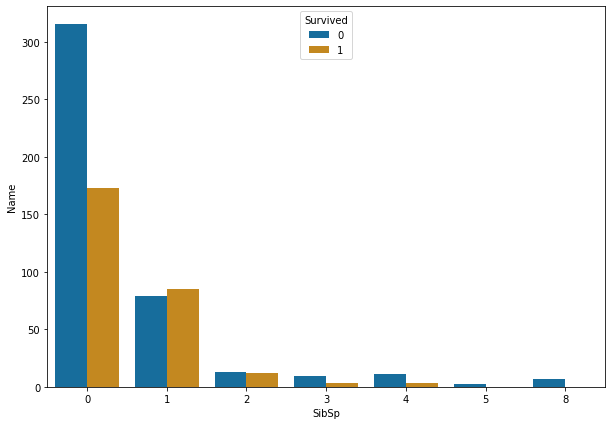

In [817]:
gb = family[['SibSp','Name', 'Survived']].groupby(['SibSp','Survived']).count()
gb.reset_index(inplace=True)
gb.sort_values(by='SibSp', ascending=False)
plt.figure(figsize=(10,7))
ax = sns.barplot(x='SibSp', y='Name', hue='Survived'
                 , data=gb)
# Most passengers did not have a sibling or spouse on board. 
#The survival rates look better for people with 1 or 2 siblings/spouses

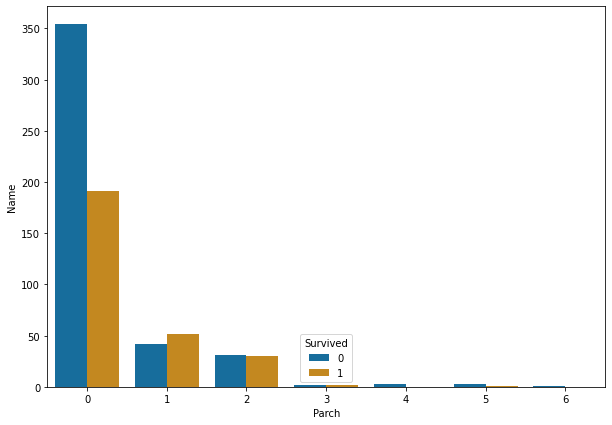

In [818]:
gb = family[['Parch','Name', 'Survived']].groupby(['Parch','Survived']).count()
gb.reset_index(inplace=True)
gb.sort_values(by='Parch', ascending=False)
plt.figure(figsize=(10,7))
ax = sns.barplot(x='Parch', y='Name', hue='Survived'
                 , data=gb)
# Most passengers traveled alone. Survival rate is improved for 1 or 2 children/parents 

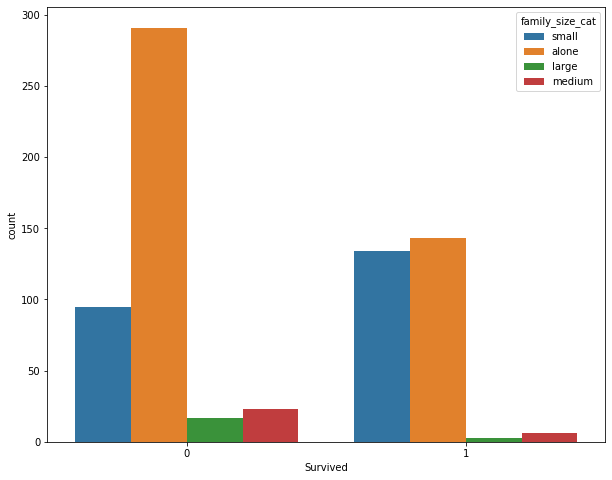

In [7]:
# create family size feature 

#Train Data 
df_train['family_size'] = df_train['Parch']+df_train['SibSp']+1 
df_train['family_size'].value_counts().sort_index()
family_size_map = {1: 'alone', 2: 'small', 3: 'small', 4: 'small', 5: 'medium', 6: 'medium', 7: 'large', 
                   8: 'large', 11: 'large'}
df_train['family_size_cat'] = df_train['family_size'].map(family_size_map)

#Test data 
df_test['family_size'] = df_test['Parch']+df_test['SibSp']+1 
df_test['family_size'].value_counts().sort_index()
family_size_map = {1: 'alone', 2: 'small', 3: 'small', 4: 'small', 5: 'medium', 6: 'medium', 7: 'large', 
                   8: 'large', 11: 'large'}
df_test['family_size_cat'] = df_test['family_size'].map(family_size_map)

# Plot df_train on family size
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='Survived', hue='family_size_cat', data=df_train)
plt.show()


In [63]:
#Step 5: Baseline model + Evaluation metrics - Logistic Regression, Random Forest

# Let's use only Pclass, the strongest predictor of Survival classification

Xtrain = df_train[['Pclass']] 
Xtest = df_test[['Pclass']]

ytrain = df_train['Survived'] 
ytest = df_test['Survived']

Xtrain.shape, ytrain.shape


((28872, 1), (28872,))

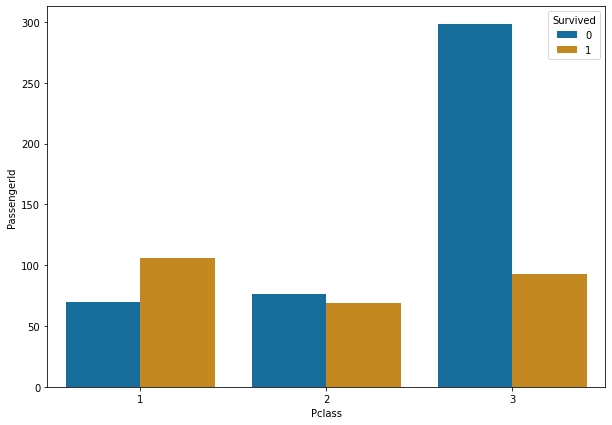

In [343]:
# Select treshold and create baseline model with just Pclass

gb = df_train[['PassengerId','Pclass', 'Survived']].groupby(['Pclass','Survived']).count()
gb.reset_index(inplace=True)
plt.figure(figsize=(10,7))
ax = sns.barplot(x='Pclass', y='PassengerId', hue='Survived'
                 , data=gb)
#If pclass = 1 => passenger survived
#If pclass = 2 => passenger survived but with 60% probability (uncertain)
#If pclass = 3 => passenger not survived

In [347]:
threshold = 3

def predict(x):
    if x < threshold:
        return 1 # Survived
    else:
        return 0 #'Non Survived'

ypred = Xtrain['Pclass'].apply(predict)  # runs a function over all values

acc = round(accuracy_score(ypred,ytrain),3)
prec = round(precision_score(ytrain, ypred), 2)
rec = round(recall_score(ytrain, ypred),2)
f1_score = round(f1_score(ytrain, ypred),2)

print(classification_report(ytrain, ypred))


              precision    recall  f1-score   support

           0       0.76      0.67      0.71       444
           1       0.55      0.65      0.59       268

    accuracy                           0.66       712
   macro avg       0.65      0.66      0.65       712
weighted avg       0.68      0.66      0.67       712



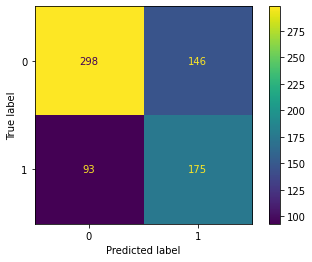

In [348]:
cm = confusion_matrix(ytrain, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

#Comments: the baseline predicts the true values better on the non survived group, but overall model is not very good
#Accuracy (how precise the model is): the accuracy is not good for survived group (a lot of false positives)
# Recall (how many positives the model capture): not very high in neither of the passenger groups

In [64]:
# Baseline Decision Tree Classifier 

def train_decision_tree(Xtrain,ytrain,Xtest, ytest,tree_depth):
    m_tree = DecisionTreeClassifier(max_depth=tree_depth)  
    m_tree.fit(Xtrain.values, ytrain.values)

    ypred_tree = m_tree.predict(Xtrain.values)
    print(classification_report(ytrain.values, ypred_tree))
    print(f'crossvalidatin for DecisionTree is {cross_val_score(m_tree, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data')
    print("training DecTree accuracy = ",   round(m_tree.score(Xtrain.values, ytrain.values),2))
    print("validation DecTree accuracy = ", round(m_tree.score(Xtest.values, ytest.values), 2))
    
train_decision_tree(Xtrain,ytrain,Xtest, ytest,3)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79     19124
           1       0.56      0.32      0.41      9748

    accuracy                           0.69     28872
   macro avg       0.64      0.60      0.60     28872
weighted avg       0.66      0.69      0.66     28872

crossvalidatin for DecisionTree is [0.69142857 0.71324675 0.65968133 0.63612747 0.73051611]

Comparison with test data
training DecTree accuracy =  0.69
validation DecTree accuracy =  0.71


In [65]:
#Baseline Logistic Regression
def train_logistic_regression(Xtrain,ytrain,Xtest, ytest):
    m = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs')
    m.fit(Xtrain.values, ytrain.values)
    ypred_log = m.predict(Xtrain.values)
    print(classification_report(ytrain.values, ypred_log))
    print(f'crossvalidatin for LogReg is {cross_val_score(m, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data')
    print("training LogReg accuracy = ",   round(m.score(Xtrain.values, ytrain.values),2))
    print("validation LogReg accuracy = ", round(m.score(Xtest.values, ytest.values), 2))
    
train_logistic_regression(Xtrain,ytrain,Xtest, ytest)

              precision    recall  f1-score   support

           0       0.74      0.77      0.75     19124
           1       0.51      0.47      0.49      9748

    accuracy                           0.67     28872
   macro avg       0.63      0.62      0.62     28872
weighted avg       0.66      0.67      0.67     28872

crossvalidatin for LogReg is [0.62822511 0.68883117 0.65968133 0.69587807 0.66868722]

Comparison with test data
training LogReg accuracy =  0.67
validation LogReg accuracy =  0.7


prediction for [[1]] class is    1.000
probability for Non Survived(0) is  0.243
probability for Survived(1) is      0.757


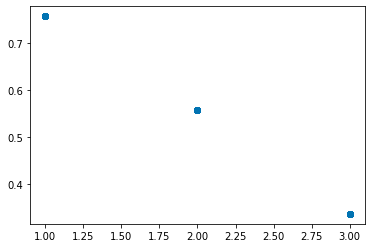

In [851]:
# Predictions and probabilities - Logistic Regression
tux = [[1]] 
d = m.predict(tux)
p = m.predict_proba(tux) 
print(f'prediction for {tux} class is   {d[0]:6.3f}')
print(f'probability for Non Survived(0) is {p[0][0]:6.3f}')
print(f'probability for Survived(1) is     {p[0][1]:6.3f}')
plt.scatter(x = Xtrain.values, y=m.predict_proba(Xtrain.values)[:,1])

In [10]:
#Baseline Random Forest
def train_randomforest(Xtrain,ytrain,Xtest, ytest):
    r = RandomForestClassifier()
    r.fit(Xtrain.values, ytrain.values)
    ypred_rf = r.predict(Xtrain.values)
    print(classification_report(ytrain.values, ypred_rf))
    print(f'crossvalidatin for RF is {cross_val_score(r, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data:')
    print("training RF accuracy = ",       round(r.score(Xtrain.values, ytrain.values),2))
    print("validation RF accuracy = ",     round(r.score(Xtest.values, ytest.values),2))

train_randomforest(Xtrain,ytrain,Xtest, ytest)

              precision    recall  f1-score   support

           0       0.69      0.86      0.77       434
           1       0.65      0.40      0.49       278

    accuracy                           0.68       712
   macro avg       0.67      0.63      0.63       712
weighted avg       0.67      0.68      0.66       712

crossvalidatin for RF is [0.65034965 0.63636364 0.66901408 0.6971831  0.68309859]

Comparison with test data:
training RF accuracy =  0.68
validation RF accuracy =  0.67


In [959]:
#Step 6: Feature Engineering 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 711
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      712 non-null    category
 1   Survived         712 non-null    int64   
 2   Pclass           712 non-null    int64   
 3   Name             712 non-null    category
 4   Sex              712 non-null    category
 5   Age              712 non-null    float64 
 6   SibSp            712 non-null    int64   
 7   Parch            712 non-null    int64   
 8   Ticket           712 non-null    category
 9   Fare             712 non-null    float64 
 10  Cabin            712 non-null    category
 11  Embarked         711 non-null    category
 12  Surname          712 non-null    object  
 13  FirstName        712 non-null    object  
 14  PrefixName       712 non-null    object  
 15  family_size      712 non-null    int64   
 16  family_size_cat  712 non-null    object  
dt

In [8]:
#Drop unecessary variables 
df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'FirstName'], inplace=True, axis=1)
df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'FirstName'], inplace=True, axis=1)

In [9]:
# Age: bin it in groups 

#Train data 
kbins = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')
columns = df_train[['Age']]
kbins.fit(columns)
t = kbins.transform(columns)

edges = kbins.bin_edges_[0].round(1)
labels = []
for i in range(len(edges)-1):
    edge1 = edges[i]
    edge2 = edges[i+1]
    labels.append(f"{edge1}_to_{edge2}")

df_bins = pd.DataFrame(t, columns=labels)
df_bins['Age'] = df_train['Age']
df_train = df_train.merge(df_bins)


#Test data 
kbins = KBinsDiscretizer(n_bins=7, encode='onehot-dense', strategy='quantile')
tcolumns = df_test[['Age']]
kbins.fit(tcolumns)
tt = kbins.transform(tcolumns)

edges = kbins.bin_edges_[0].round(1)
labels = []
for i in range(len(edges)-1):
    edge1 = edges[i]
    edge2 = edges[i+1]
    labels.append(f"{edge1}_to_{edge2}")

df_bins = pd.DataFrame(tt, columns=labels)
df_bins['Age'] = df_test['Age']
df_test = df_test.merge(df_bins)


In [ ]:
df_train.info()

In [10]:
# Fare: Normalize values

# Train data 
scaler = StandardScaler()
cols = df_train[['Fare']]
scaler.fit(cols)   
s = scaler.transform(cols) 
cols_scaled = pd.DataFrame(s, columns=cols.columns)
df_train['Fare_scaled'] = cols_scaled

# Test Data 
scaler = StandardScaler()
cols = df_test[['Fare']]
scaler.fit(cols)   
s = scaler.transform(cols) 
cols_scaled = pd.DataFrame(s, columns=cols.columns)
df_test['Fare_scaled'] = cols_scaled


In [69]:
df_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Surname', 'PrefixName', 'family_size', 'family_size_cat',
       '0.4_to_21.0', '21.0_to_28.2', '28.2_to_29.7', '29.7_to_38.0',
       '38.0_to_80.0', 'Fare_scaled'],
      dtype='object')

In [47]:
# Pipeline with make_pipeline and make_column_transformer 

categorical_pipe = make_pipeline(OneHotEncoder())

numeric_pipe = make_pipeline(StandardScaler())

feature_transform = make_column_transformer(
    
                    (categorical_pipe, ['Sex','Embarked', 'family_size_cat']),
    
                    (numeric_pipe, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'family_size']) )

pipeline = make_pipeline(feature_transform, LogisticRegression())

# X and y datasets 

Xtrain = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'family_size', 'family_size_cat']]  
Xtest = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'family_size', 'family_size_cat']]  

ytrain = df_train['Survived']
ytest = df_test['Survived']



## get pipeline feature names

pipeline.fit(Xtrain, ytrain)
pipeline[:-1].get_feature_names_out()


## specify feature names as your columns
Xtrain_transformed = pd.DataFrame(pipeline[:-1].transform(Xtrain),
                     columns=pipeline[:-1].get_feature_names_out(),
                     index=Xtrain.index)



In [49]:
# Random Forest 


def train_randomforest(Xtrain,ytrain,Xtest, ytest):
    r = RandomForestClassifier()
    r.fit(Xtrain, ytrain)
    ypred_rf = r.predict(Xtrain)
    print(classification_report(ytrain.values, ypred_rf))
    print(f'crossvalidatin for RF is {cross_val_score(r, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data:')
    print("training RF accuracy = ",       round(r.score(Xtrain, ytrain),2))
    print("validation RF accuracy = ",     round(r.score(Xtest, ytest),2))


pipeline_rf = make_pipeline(feature_transform, RandomForestClassifier())


## get pipeline feature names

pipeline_rf.fit(Xtrain, ytrain)
pipeline_rf[-1].get_feature_names_out()


AttributeError: 'RandomForestClassifier' object has no attribute 'get_feature_names_out'

In [ ]:
## specify feature names as your columns
Xtrain_transformed_RF = pd.DataFrame(pipeline_rf[-1].transform(Xtrain),
                     columns=pipeline_rf[:-1].get_feature_names_out(),
                     index=Xtrain.index)

In [38]:

def train_decision_tree(Xtrain,ytrain,Xtest, ytest,tree_depth):
    
    m_tree = DecisionTreeClassifier(max_depth=tree_depth)  
    
    m_tree.fit(Xtrain, ytrain)

    ypred_tree = m_tree.predict(Xtrain)
    print(classification_report(ytrain, ypred_tree))
    print(f'crossvalidatin for DecisionTree is {cross_val_score(m_tree, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data')
    print("training DecTree accuracy = ",   round(m_tree.score(Xtrain, ytrain),2))
    print("validation DecTree accuracy = ", round(m_tree.score(Xtest, ytest), 2))
    
train_decision_tree(Xtrain_transformed,ytrain,Xtest_transformed, ytest,6)


              precision    recall  f1-score   support

           0       0.89      0.97      0.93     17815
           1       0.94      0.77      0.84      9473

    accuracy                           0.90     27288
   macro avg       0.91      0.87      0.89     27288
weighted avg       0.90      0.90      0.90     27288

crossvalidatin for DecisionTree is [0.81476731 0.94833272 0.76749725 0.80538758 0.66721642]

Comparison with test data
training DecTree accuracy =  0.9
validation DecTree accuracy =  0.86


/home/rita/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [39]:
def train_logistic_regression(Xtrain,ytrain,Xtest, ytest):
    m = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='newton-cg')
    m.fit(Xtrain, ytrain)
    ypred_log = m.predict(Xtrain)
    print(classification_report(ytrain, ypred_log))
    print(f'crossvalidatin for LogReg is {cross_val_score(m, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data')
    print("training LogReg accuracy = ",   round(m.score(Xtrain, ytrain),2))
    print("validation LogReg accuracy = ", round(m.score(Xtest, ytest), 2))
    
train_logistic_regression(Xtrain_transformed,ytrain,Xtest_transformed, ytest)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     17815
           1       0.71      0.71      0.71      9473

    accuracy                           0.80     27288
   macro avg       0.78      0.78      0.78     27288
weighted avg       0.80      0.80      0.80     27288

crossvalidatin for LogReg is [0.83418835 0.79076585 0.79333089 0.74876306 0.7694704 ]

Comparison with test data
training LogReg accuracy =  0.8
validation LogReg accuracy =  0.87


/home/rita/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [40]:
def train_randomforest(Xtrain,ytrain,Xtest, ytest):
    r = RandomForestClassifier()
    r.fit(Xtrain, ytrain)
    ypred_rf = r.predict(Xtrain)
    print(classification_report(ytrain.values, ypred_rf))
    print(f'crossvalidatin for RF is {cross_val_score(r, Xtrain, ytrain)}')
    print('')
    print('Comparison with test data:')
    print("training RF accuracy = ",       round(r.score(Xtrain, ytrain),2))
    print("validation RF accuracy = ",     round(r.score(Xtest, ytest),2))


train_randomforest(Xtrain_transformed,ytrain,Xtest_transformed, ytest)


              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17815
           1       0.97      0.93      0.95      9473

    accuracy                           0.96     27288
   macro avg       0.97      0.96      0.96     27288
weighted avg       0.96      0.96      0.96     27288

crossvalidatin for RF is [0.90161231 0.84499817 0.76749725 0.78138171 0.62048745]

Comparison with test data:
training RF accuracy =  0.96
validation RF accuracy =  0.89


/home/rita/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Decision Tree and Random Forest have the highest precision and accuracy, RF better recall, but both highly overfitted
# Logistic Regression has the lowest precison and accuracy, but the results on test data are on par with the training data 

#Are we picking the right variables?
#Are we including too many variables?
#Are we defining the right relationships btwe target and predictors? 

In [41]:
Xtrain_transformed

,pipeline-1__Sex_female,pipeline-1__Sex_male,pipeline-1__Embarked_C,pipeline-1__Embarked_Q,pipeline-1__Embarked_S,pipeline-1__Embarked_nan,pipeline-1__family_size_cat_alone,pipeline-1__family_size_cat_large,pipeline-1__family_size_cat_medium,pipeline-1__family_size_cat_small,pipeline-2__Pclass,pipeline-2__Age,pipeline-2__SibSp,pipeline-2__Parch,pipeline-2__Fare,pipeline-2__family_size
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,-4.699998,-0.348675,2.859333,1.418929,0.714320
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,-4.699998,-0.348675,2.859333,1.418929,0.714320
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,-4.699998,-0.348675,2.859333,1.418929,0.714320
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,-4.699998,-0.348675,2.859333,1.418929,0.714320
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,-4.699998,-0.348675,2.859333,1.418929,0.714320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27283,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,6.324994,0.373225,-0.368662,1.320985,0.159977
27284,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.814431,6.324994,0.373225,-0.368662,1.320985,0.159977
27285,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.654759,6.324994,-0.348675,-0.368662,-0.396076,-0.394366
27286,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.654759,6.324994,-0.348675,-0.368662,-0.396076,-0.394366


In [43]:
# Feature Selection
# Coeficients analysis with Logistic Regression using statsmodels package 
# Before transformations 

ytrain = df_train['Survived']

Xtrain = df_train[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']]

np.seterr(divide = 'ignore') 
                   
log_reg = sm.Logit(ytrain, sm.add_constant(Xtrain)).fit()

print(log_reg.summary())


Optimization terminated successfully.
         Current function value: 0.608977
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                27288
Model:                          Logit   Df Residuals:                    27282
Method:                           MLE   Df Model:                            5
Date:                Sat, 27 Nov 2021   Pseudo R-squ.:                 0.05682
Time:                        18:03:25   Log-Likelihood:                -16618.
converged:                       True   LL-Null:                       -17619.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1949      0.096      2.022      0.043       0.006       0.384
Pclass        -0.2519      0.

In [ ]:

#Feature Expansion
#Survived non linear relationships with regressors: 
# Interactions
pt = PolynomialFeatures(interaction_only=True)
p_features = pt.fit_transform(X)
pd.DataFrame(p_features, columns=pt.get_feature_names())

# Polynoms 
p = PolynomialFeatures(degree=4, , include_bias=False)
X = p.fit_transform(X)
X = pd.DataFrame(X, columns=p.get_feature_names())
Xpoly = p.transform(X[['x']])
df_poly = pd.DataFrame(Xpoly, columns = p.get_feature_names())
m.fit(X, y)
ypred_p2 = m.predict(X)


In [44]:
#Recursive Feature Elimination / Logistic Regression 

#def get_recursive_feature_elimination(model,X_train, y_train):

m = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='newton-cg')

m.fit(Xtrain_transformed_df, ytrain) 

print(list(zip(Xtrain_transformed_df.columns,m.support_, m.ranking_)))

print(model.score(Xtrain_transformed_df, y_train))


AttributeError: 'LogisticRegression' object has no attribute 'support_'

In [146]:
# RandomForest Feature Importance
def get_rf_feature_importance(rf, X_train):
    pd.DataFrame({'importance': rf.feature_importances_, 'feature': X_train.columns}).\
    df.sort_values('importance', ascending=False)
    print(df)
    

rf = RandomForestClassifier(max_depth=5,random_state=0)
rf.fit(Xtrain_transformed, ytrain)

pd.DataFrame({'importance': rf.feature_importances_, 'feature': Xtrain_transformed_df.columns}).\
sort_values('importance', ascending=False)   #feature_importance- use for RF model


,importance,feature
1,0.195160,1
17,0.161532,17
0,0.146094,0
27,0.087229,27
14,0.060425,14
18,0.057976,18
28,0.054505,28
32,0.046183,32
4,0.042680,4
30,0.033590,30


In [478]:
###Step 7: Iterate the transformed models. Optimize hyperparameters 

Xtrain = df_train[['Pclass', 'Age']]  
Xtest = df_test[['Pclass', 'Age']]

ytrain = df_train['Survived'] 
ytest = df_test['Survived']

train_decision_tree(Xtrain,ytrain,Xtest, ytest,3)
train_logistic_regression(Xtrain,ytrain,Xtest, ytest)
train_randomforest(Xtrain,ytrain,Xtest, ytest)

In [597]:
###Step 8: Make predictions for Titanic Kaggle challenge and submit results 

# Get test data 
test = pd.read_csv('test.csv')

# Pre-Process it 
test['Age'].fillna('999', inplace=True)
test['Age'] = pd.to_numeric(test_input['Age'])
test['Age'].fillna(test['Age'].mean(), inplace=True)
test_input = test[['Pclass', 'Age']]

# Generate CSV with predictions for the 418 passengers of test.csv 
# This file should have 2 columns only: PassengerId and Survived 
titanic_pred = pd.DataFrame(rf2.predict(test_input), columns=['Survived'])
titanic_pred['PassengerId'] = test['PassengerId']
titanic_pred = titanic_pred[['PassengerId', 'Survived']]
path = '/home/rita/Documents/GitHub/git_colab/week02/titanic_pred'
titanic_pred.to_csv(path)
